In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pulp import *
import math
from ortools.linear_solver import pywraplp
sns.set()

In [2]:
production = pd.read_csv("production.csv")
purchasing = pd.read_csv("purchasing.csv")
bom = pd.read_csv('bom.csv')
stock = pd.read_csv("stock.csv")
components = pd.read_csv('components.csv')
articles = pd.read_csv("articles.csv")

purchasing['date'] = pd.to_datetime(purchasing['date'])
production['date']  = pd.to_datetime(production['date'])
stock['date'] = pd.to_datetime(stock['date'])

#preprocess stock and purchasing to work with follow ups
def processFollowUp(components, stock, purchasing, bom):
    #replace new component numbers for old component numbers in stock, purchasing, bom
    replaceDict = components[~np.isnan(components['follow_up_component'])][['component_number','follow_up_component']].astype('int').set_index('follow_up_component')['component_number'].to_dict()
    purchasing['component_number'] = purchasing['component_number'].replace(replaceDict)
    stock['component_number'] = stock['component_number'].replace(replaceDict)
    bom['component_number'] = bom['component_number'].replace(replaceDict)
    return stock, purchasing, bom

stock, purchasing, bom = processFollowUp(components, stock, purchasing, bom)


allComponents = set(bom['component_number']) | set(purchasing['component_number']) | set(stock['component_number'])

productionDays = list(production['date'].sort_values(ascending=True).unique())
purchasingDays = list(purchasing['date'].unique())
allDays = sorted(productionDays + purchasingDays)
allDays = list(dict.fromkeys(allDays))
day0 = allDays[0] 

#drop duplicates in bom for now, later allow for bom changes
bom = bom.drop_duplicates(subset=['article_number','component_number'])

In [3]:
print(f"Total window for which production schedule is required: {production['date'].min()} - {production['date'].max()}")

Total window for which production schedule is required: 2022-02-16 00:00:00 - 2022-08-15 00:00:00


In [4]:
#general cnfiguration
class Config():
    DAY_PRODUCTION_CAPACITY = 1000
    X_CAT = 'Integer'
    BATCH_SIZE = 16
    DAY_BATCH_PRODUCTION_CAPACITY = (DAY_PRODUCTION_CAPACITY/BATCH_SIZE)

### Pre processing

##### Add beginning inventory as purchase on day 0, to make simpler

In [5]:
def processNegativePurchasing(stock, purchasing):
    purchasingProcessed = purchasing.copy()
    purchasingProcessed = pd.concat([stock, purchasing])
    purchasingProcessed = purchasingProcessed.groupby(by=["component_number", "date"]).sum().reset_index().sort_values(by=['date','component_number'])

    for componentNumber in tqdm(purchasing['component_number'].unique()):
        stockOverTime = purchasingProcessed.loc[purchasingProcessed['component_number'] == componentNumber, "quantity"].cumsum()
        stockOverTimeMonotonicallyIncreasing = pd.Series(index = stockOverTime.index, data = np.minimum.accumulate(stockOverTime[::-1]))
        componentProcessedPurchasing = stockOverTimeMonotonicallyIncreasing - stockOverTimeMonotonicallyIncreasing.shift(1, fill_value=0)
        purchasingProcessed.loc[purchasingProcessed['component_number'] == componentNumber, 'quantity'] = componentProcessedPurchasing.values
    return purchasingProcessed

In [6]:
purchasingProcessed = processNegativePurchasing(stock, purchasing)

100%|██████████| 1335/1335 [00:02<00:00, 522.71it/s]


In [7]:
class Inventory(object):
    def __init__(self, purchasing: pd.DataFrame):
        self.purchasing = purchasing

    def purchasingForDay(self, date, componentNumber = None):
        date = self.checkTimestamp(date)

        if componentNumber is None:
            #returns pd.Series with component_number as index & quantity
            return self.purchasing[self.purchasing['date'] == date].set_index('component_number')['quantity'].reindex(allComponents, fill_value=0)
        else:
            #returns int with quantity
            return self.purchasing[(self.purchasing['date'] == date) & (self.purchasing['component_number'] == componentNumber)]['quantity'].sum()

    def purchasingForPeriod(self, beginDate, endDate, componentNumber = None, inclusive=True):

        beginDate, endDate = self.checkTimestamp(beginDate), self.checkTimestamp(endDate)

        if componentNumber is None:
            #returns pd.Series with component_number as index & quantity
            res = self.purchasing[self.purchasing['date'].between(beginDate, endDate, inclusive = inclusive)].groupby(by = 'component_number')['quantity'].sum().reindex(allComponents, fill_value=0)
            res[res<0] = 0
            return res 
            
        else:
            #returns int with quantity
            return self.purchasing[(self.purchasing['date'].between(beginDate, endDate, inclusive = inclusive)) & (self.purchasing['component_number'] == componentNumber)]['quantity'].sum()

    def checkTimestamp(self, date):
        if type(date) is str:
            return pd.Timestamp(date)
        else:
            return date


In [8]:
test = Inventory(purchasingProcessed)

In [9]:
print(test.purchasingForDay('2022-02-16', 25))
print()
print(test.purchasingForDay('2022-02-16'))
print()
print(test.purchasingForPeriod('2022-02-16', '2022-05-19', componentNumber=25, inclusive=True))
print()
print(test.purchasingForPeriod('2022-02-16', '2022-05-19', inclusive=True))

-16853

component_number
0        2297
1        1998
2           0
3        4074
4        4842
        ...  
1389    13462
1390      691
1391     6586
1392        0
1393    13100
Name: quantity, Length: 1380, dtype: int64

-16853

component_number
0        2297
1        1998
2         840
3       14074
4        6842
        ...  
1389    23062
1390      691
1391     6586
1392        0
1393    16540
Name: quantity, Length: 1380, dtype: int64


In [10]:
class ProductionDayManager(object):
    def __init__(self, productionDays: list):
        self.productionDaysArr = np.array(allProductionDays)

    def daysInPeriod(self, beginDay, endDay, inclusive = True):
        if inclusive:
            return self.productionDaysArr[self.productionDaysArr >= beginDay & self.productionDaysArr <= endDay]
        else:
            return self.productionDaysArr[self.productionDaysArr >= beginDay & self.productionDaysArr < endDay]


In [11]:
def createPeriods(beginDate, endDate, nPeriods, inclusive=False):
    beginDate = pd.Timestamp(beginDate)
    endDate = pd.Timestamp(endDate)
    length = (endDate - beginDate).days
    lengthPerPeriod = int(length/nPeriods)
    res = []
    for i in range(nPeriods-1):
        addDay = (not inclusive) and (i is not 0)
        periodBegin =  beginDate + pd.Timedelta(days= i * lengthPerPeriod + addDay)
        periodEnd = beginDate + pd.Timedelta(days= (i+1) * lengthPerPeriod)
        res.append((periodBegin, periodEnd))
    
    res.append((res[-1][-1] + pd.Timedelta(days=int(not inclusive)), endDate))
    return res

In [12]:
def getBusDaysInPeriod(periodBegin: pd.Timestamp, periodEnd: pd.Timestamp):
    return list(pd.bdate_range(periodBegin, periodEnd))

In [13]:
def nBusDays(periodBegin: pd.Timestamp, periodEnd: pd.Timestamp):
    periodBegin = periodBegin.to_pydatetime().date()
    periodEnd= periodEnd.to_pydatetime().date()
    return np.busday_count(periodBegin, periodEnd)

In [14]:
def convertToBatchSize(bom, articles, batchSize):
    # bom quantities * batchSize
    # articles revenue * 16
    bomProcessed = bom.copy()
    articlesProcessed = articles.copy()
    bomProcessed['quantity'] = bomProcessed['quantity'] * batchSize
    articlesProcessed['revenue'] = articlesProcessed['revenue'] * batchSize
    return bomProcessed, articlesProcessed

In [15]:
bomBatch, articlesBatch = convertToBatchSize(bom, articles, Config.BATCH_SIZE)

### Simple per period planning
Each period, take available inventories at beginning of periiod

In [16]:
def getComponentsRequired(componentNumber, bom):
    required = bom[(bom['component_number'] == componentNumber)]
    if len(required) == 0:
        return 0
    return required.set_index("article_number")['quantity']

In [ ]:
periods = createPeriods('2022-02-16', '2022-05-19', 2)
print(f"Period length: {(periods[0][1] -periods[0][0]).days}")
period0 = (pd.Timestamp('2000-01-01'), periods[0][0]) #only beginning inventory
lastPeriod = (periods[-1][-1], pd.Timestamp('2100-01-01'))
periods = [period0] + periods + [lastPeriod]


productionDf = pd.DataFrame(columns=['article_number','period', 'periodNumber','quantity_batch'])
for periodNumber, period in enumerate(periods[:-1]):
    periodBegin = period[0]
    periodEnd= period[1]
    ##replace this with for loop in a bit
    inv = Inventory(purchasingProcessed)
    availableInv = inv.purchasingForPeriod(periodBegin, periodEnd)
    print(periodNumber, periodBegin, periodEnd)
    periodLength = (periodEnd - periodBegin).days
    model = LpProblem(name='Production', sense=LpMaximize)

    #variables that represent quantity of article i produced
    #x: #batches
    x = {i: LpVariable(name=f"x{i}", lowBound=0, upBound=Config.DAY_BATCH_PRODUCTION_CAPACITY*periodLength, cat=Config.X_CAT) for i in articles['article_number']}


    #Objective
    revenue = articlesBatch.set_index('article_number')['revenue'].to_dict()
    model += lpSum(x[i] * revenue[i] for i in x.keys())

    #Constraint component usage
    for j in tqdm(allComponents):
        componentsRequired = getComponentsRequired(j, bomBatch) #returns series wirh index article_number and value quantity
        affineDict = {x[i]: quantity for i, quantity in componentsRequired.iteritems()}
        #print(affineDict)
        model += LpAffineExpression(affineDict) <= availableInv[j], f"Constraint component {j}"
        #model += lpSum([x[i] * quantity for i, quantity in componentsRequired.iteritems()]) <= availableInv[j], f"Constraint component {j}"
    #print(model)
    status = model.solve()
    print(f"Period solved with status {status}")
    periodProduction = [{'article_number':i,'quantity_batch':_.value(),'periodNumber':periodNumber, 'period': periods[periodNumber+1]} for i,_ in x.items() if _.value() > 0]
    print(periodProduction)
    productionDf = productionDf.append(periodProduction, ignore_index=True)


Period length: 46
0 2000-01-01 00:00:00 2022-02-16 00:00:00
100%|██████████| 1380/1380 [00:01<00:00, 933.27it/s]
Period solved with status 1
[{'article_number': 287, 'quantity_batch': 13.0, 'periodNumber': 0, 'period': (Timestamp('2022-02-16 00:00:00'), Timestamp('2022-04-03 00:00:00'))}, {'article_number': 174, 'quantity_batch': 1.0, 'periodNumber': 0, 'period': (Timestamp('2022-02-16 00:00:00'), Timestamp('2022-04-03 00:00:00'))}, {'article_number': 66, 'quantity_batch': 1.0, 'periodNumber': 0, 'period': (Timestamp('2022-02-16 00:00:00'), Timestamp('2022-04-03 00:00:00'))}, {'article_number': 124, 'quantity_batch': 1.0, 'periodNumber': 0, 'period': (Timestamp('2022-02-16 00:00:00'), Timestamp('2022-04-03 00:00:00'))}, {'article_number': 137, 'quantity_batch': 2.0, 'periodNumber': 0, 'period': (Timestamp('2022-02-16 00:00:00'), Timestamp('2022-04-03 00:00:00'))}, {'article_number': 404, 'quantity_batch': 2.0, 'periodNumber': 0, 'period': (Timestamp('2022-02-16 00:00:00'), Timestamp('2

In [ ]:
productionDf

,article_number,period,periodNumber,quantity_batch
0,287,"(2022-02-16 00:00:00, 2022-04-03 00:00:00)",0,13.0
1,174,"(2022-02-16 00:00:00, 2022-04-03 00:00:00)",0,1.0
2,66,"(2022-02-16 00:00:00, 2022-04-03 00:00:00)",0,1.0
3,124,"(2022-02-16 00:00:00, 2022-04-03 00:00:00)",0,1.0
4,137,"(2022-02-16 00:00:00, 2022-04-03 00:00:00)",0,2.0
5,404,"(2022-02-16 00:00:00, 2022-04-03 00:00:00)",0,2.0
6,11,"(2022-02-16 00:00:00, 2022-04-03 00:00:00)",0,1.0
7,44,"(2022-02-16 00:00:00, 2022-04-03 00:00:00)",0,1.0
8,79,"(2022-02-16 00:00:00, 2022-04-03 00:00:00)",0,3.0
9,98,"(2022-02-16 00:00:00, 2022-04-03 00:00:00)",0,18.0


In [ ]:
print(productionDf['quantity_batch'].sum() * Config.BATCH_SIZE)

25792.0


In [ ]:
print(model.objective.value())
print({i:_.value() for i,_ in x.items()})
productionDict = {i:_.value() for i,_ in x.items()}
productionDf = pd.DataFrame( productionDict.values(), index = productionDict.keys(), columns=['quantity'])

0.0
{472: 0.0, 434: 0.0, 240: 0.0, 452: 0.0, 107: 0.0, 335: 0.0, 484: 0.0, 210: 0.0, 292: 0.0, 63: 0.0, 380: 0.0, 108: 0.0, 258: 0.0, 459: 0.0, 489: 0.0, 104: 0.0, 91: 0.0, 158: 0.0, 475: 0.0, 242: 0.0, 378: 0.0, 203: 0.0, 206: 0.0, 448: 0.0, 170: 0.0, 492: 0.0, 176: 0.0, 337: 0.0, 287: 0.0, 286: 0.0, 331: 0.0, 95: 0.0, 491: 0.0, 327: 0.0, 131: 0.0, 4: 0.0, 174: 0.0, 288: 0.0, 171: 0.0, 397: 0.0, 88: 0.0, 273: 0.0, 432: 0.0, 222: 0.0, 127: 0.0, 46: 0.0, 247: 0.0, 343: 0.0, 29: 0.0, 267: 0.0, 447: 0.0, 101: 0.0, 329: 0.0, 355: 0.0, 237: 0.0, 393: 0.0, 297: 0.0, 135: 0.0, 457: 0.0, 401: 0.0, 467: 0.0, 213: 0.0, 66: 0.0, 103: 0.0, 81: 0.0, 290: 0.0, 395: 0.0, 334: 0.0, 53: 0.0, 388: 0.0, 309: 0.0, 24: 0.0, 148: 0.0, 120: 0.0, 333: 0.0, 96: 0.0, 25: 0.0, 493: 0.0, 450: 0.0, 438: 0.0, 436: 0.0, 261: 0.0, 179: 0.0, 190: 0.0, 302: 0.0, 462: 0.0, 57: 0.0, 354: 0.0, 427: 0.0, 365: 0.0, 8: 0.0, 458: 0.0, 23: 0.0, 7: 0.0, 304: 0.0, 474: 0.0, 367: 0.0, 211: 0.0, 192: 0.0, 169: 0.0, 426: 0.0, 181: 

In [ ]:
productionDf[productionDf['quantity'] > 0]

,quantity


### Multi period formulation

P: production capacity per day \
$r_i$: revenue article i \
$q_{ij}$: Amount of component j needed for article i \
$x_{it}$: Quantity produced of article i on day t \
$d_{jt}$: Purchasing of component j arriving at the beggining of day t \
$T$ total duration of the period 


Objective: \
$Maximize$ $ \sum_{t=1}^T \sum_{i=1}^n x_{it}r_{i}$ \
st.  

$\sum_{t'=1}^{t}d_{jt'} - \sum_{t'=1}^{t} \sum_{i=1}^nx_{it'}q_{ij} >= 0 \hspace{20pt} t=1,...,T \hspace{10pt} j =1,...,m$ 

$\sum_{i=1}^n x_{it} <= P \hspace{86pt} t=1,...,T $

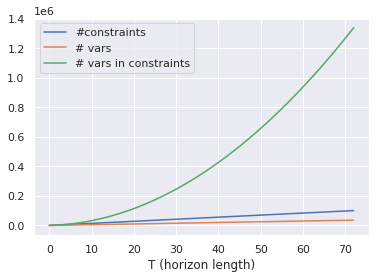

In [17]:
def plotModelSize(T, n, m):
    nConstraints = [ t*m + t for t in range(T)]
    nVars = [ t*n for t in range(T)]
    nVarsInConstraints = [t*(t+1)/2 + t*(t+1)/2 * n + t * n for t in range(T)]
    sns.lineplot(x= np.arange(0,T), y=  nConstraints, label="#constraints")
    sns.lineplot(x= np.arange(0,T), y=  nVars, label="# vars")
    sns.lineplot(x= np.arange(0,T), y=  nVarsInConstraints, label="# vars in constraints")
    plt.legend()
    plt.xlabel("T (horizon length)")
plotModelSize(T=len(productionDays), n = len(articles['article_number'].unique()), m=len(components['component_number'].unique()))

In [18]:
def multiPeriodILP(periodBegin, periodEnd, articles, purchasing, bom):
    model = LpProblem(name='Production', sense=LpMaximize)
    daysInPeriod = getBusDaysInPeriod(periodBegin, periodEnd)
    T = len(daysInPeriod)
    x = {(i, t): LpVariable(name=f"x_p_{i},d_{t}", lowBound=0, upBound=Config.DAY_PRODUCTION_CAPACITY*periodLength, cat=Config.X_CAT) for i in articles['article_number'] for t in range(0,T)}
    print(f"Multi period ILP for period {periodBegin} to {periodEnd}")
    print(f"This entails {T} days: {daysInPeriod}")
    #print(f"Created variables: {x}")
    inv = Inventory(purchasing)
    revenue = articles.set_index('article_number')['revenue'].to_dict()
    #print(revenue)
    model += lpSum(x[(i,t)] * revenue[i] for i in articles['article_number'] for t in range(0,T))

    #Inventory constraints
    for t, day in enumerate(daysInPeriod,1):
        #purchasingDay = inv.purchasingForDay(day)

        purchasingUpToDay = inv.purchasingForPeriod(daysInPeriod[0], day)

        for j in allComponents:
            print("\r", end=f"{t},{j}")
            articlesComponentUsage = getComponentsRequired(j, bom)
            model += (purchasingUpToDay[j] - lpSum([x[(i,tt)] * articlesComponentUsage[i] for i in articlesComponentUsage.index for tt in range(0,t) ])) >= 0, f"InvConstraint_day_{t-1}_component_{j}"

    #Production capacity constraints
    for t, day in enumerate(daysInPeriod):
        model += lpSum([x[(i,t)] for i in articles['article_number']]) <= Config.DAY_PRODUCTION_CAPACITY

    return model, x, daysInPeriod

In [ ]:
periodBegin = pd.Timestamp('2022-02-16')
periodEnd = pd.Timestamp('2022-03-30') 
model, x, daysInPeriod = multiPeriodILP(periodBegin = periodBegin, periodEnd = periodEnd, articles = articlesBatch, purchasing = purchasingProcessed, bom = bomBatch)

Multi period ILP for period 2022-02-16 00:00:00 to 2022-03-30 00:00:00
This entails 31 days: [Timestamp('2022-02-16 00:00:00', freq='B'), Timestamp('2022-02-17 00:00:00', freq='B'), Timestamp('2022-02-18 00:00:00', freq='B'), Timestamp('2022-02-21 00:00:00', freq='B'), Timestamp('2022-02-22 00:00:00', freq='B'), Timestamp('2022-02-23 00:00:00', freq='B'), Timestamp('2022-02-24 00:00:00', freq='B'), Timestamp('2022-02-25 00:00:00', freq='B'), Timestamp('2022-02-28 00:00:00', freq='B'), Timestamp('2022-03-01 00:00:00', freq='B'), Timestamp('2022-03-02 00:00:00', freq='B'), Timestamp('2022-03-03 00:00:00', freq='B'), Timestamp('2022-03-04 00:00:00', freq='B'), Timestamp('2022-03-07 00:00:00', freq='B'), Timestamp('2022-03-08 00:00:00', freq='B'), Timestamp('2022-03-09 00:00:00', freq='B'), Timestamp('2022-03-10 00:00:00', freq='B'), Timestamp('2022-03-11 00:00:00', freq='B'), Timestamp('2022-03-14 00:00:00', freq='B'), Timestamp('2022-03-15 00:00:00', freq='B'), Timestamp('2022-03-16 00:0

In [ ]:
model.writeMPS("test.mps")

KeyboardInterrupt: 

In [ ]:
status = model.solve()

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
status

1

In [ ]:
model.objective.value()

2766496.0

In [ ]:
print(model.objective.value())
print({i:_.value() for i,_ in x.items()})
productionDict = {i:_.value() for i,_ in x.items()}
productionDf = pd.DataFrame( productionDict.values(), index = productionDict.keys(), columns=['quantity_batch'])
productionDf = productionDf.reset_index()
productionDf.columns = ['article_number', 'day_nr', 'quantity_batch']
productionDf['day'] = productionDf['day_nr'].apply(lambda el: daysInPeriod[el])
productionDf = productionDf[['day','day_nr','article_number', 'quantity_batch']].sort_values(by=['day_nr','article_number'])
productionDf['quantity'] = productionDf['quantity_batch'] * Config.BATCH_SIZE
revenue = articles.set_index('article_number')['revenue'].to_dict()
productionDf['article_revenue'] = productionDf['article_number'].apply(lambda el: revenue[el])
productionDf['revenue_total'] = productionDf['article_revenue'] * productionDf['quantity'] 
productionDf[productionDf['quantity'] > 0]

2766496.0
{(472, 0): 0.0, (472, 1): 0.0, (472, 2): 0.0, (472, 3): 0.0, (472, 4): 0.0, (472, 5): 0.0, (472, 6): 0.0, (472, 7): 0.0, (472, 8): 0.0, (472, 9): 0.0, (472, 10): 0.0, (472, 11): 0.0, (472, 12): 0.0, (472, 13): 0.0, (472, 14): 0.0, (472, 15): 0.0, (472, 16): 0.0, (434, 0): 0.0, (434, 1): 0.0, (434, 2): 0.0, (434, 3): 0.0, (434, 4): 0.0, (434, 5): 0.0, (434, 6): 0.0, (434, 7): 0.0, (434, 8): 0.0, (434, 9): 0.0, (434, 10): 0.0, (434, 11): 0.0, (434, 12): 0.0, (434, 13): 0.0, (434, 14): 0.0, (434, 15): 0.0, (434, 16): 0.0, (240, 0): 0.0, (240, 1): 0.0, (240, 2): 0.0, (240, 3): 0.0, (240, 4): 0.0, (240, 5): 0.0, (240, 6): 0.0, (240, 7): 0.0, (240, 8): 0.0, (240, 9): 0.0, (240, 10): 0.0, (240, 11): 0.0, (240, 12): 0.0, (240, 13): 0.0, (240, 14): 0.0, (240, 15): 0.0, (240, 16): 0.0, (452, 0): 0.0, (452, 1): 0.0, (452, 2): 0.0, (452, 3): 0.0, (452, 4): 0.0, (452, 5): 0.0, (452, 6): 0.0, (452, 7): 0.0, (452, 8): 0.0, (452, 9): 0.0, (452, 10): 0.0, (452, 11): 0.0, (452, 12): 0.0, (452,

,day,day_nr,article_number,quantity_batch,quantity,article_revenue,revenue_total
477,2022-02-17,1,287,13.0,208.0,1340,278720.0
4219,2022-02-21,3,11,1.0,16.0,1028,16448.0
1058,2022-02-22,4,66,1.0,16.0,1186,18976.0
8215,2022-02-22,4,430,1.0,16.0,1673,26768.0
7620,2022-02-22,4,437,1.0,16.0,1194,19104.0
617,2022-02-23,5,174,1.0,16.0,915,14640.0
2217,2022-02-25,7,124,1.0,16.0,1046,16736.0
6249,2022-03-02,10,44,1.0,16.0,1763,28208.0
6250,2022-03-03,11,44,2.0,32.0,1763,56416.0
2680,2022-03-03,11,404,2.0,32.0,1222,39104.0


<AxesSubplot:xlabel='day'>

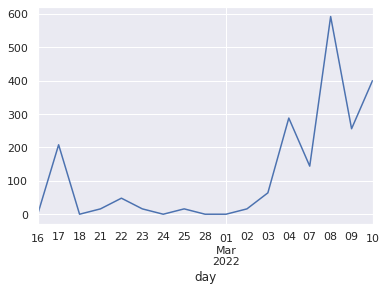

In [ ]:
productionDf.groupby(by='day').sum()['quantity'].plot()


<AxesSubplot:xlabel='day'>

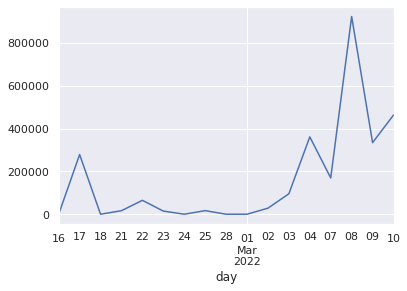

In [ ]:
productionDf.groupby(by='day').sum()['revenue_total'].plot()

In [ ]:
productionDf.groupby(by='day').sum()['revenue_total'].sum()

988240.0

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=503941b5-1736-4298-9362-1ed0707166ae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>